In [1]:
with open("requirements.txt", "r") as config_file:
    config_code = config_file.read()
    exec(config_code)
%load_ext autoreload
%autoreload 2

import statsmodels.api as sm
from linearmodels.panel import PooledOLS

In [2]:
tidy_finance = sqlite3.connect(database="data/specialedata.sqlite")

macro_predictors = (pd.read_sql_query(
    sql="SELECT * FROM macro_predictors",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("macro_")
)

JKPFactors = (pd.read_sql_query(
  sql="SELECT * FROM JKPFactors",
  con=tidy_finance,
  parse_dates={"month"})
  .add_prefix("jkp_factor_")
)
JKPFactornames = JKPFactors.columns

factors_ff3_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff3_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff3_")
)

factors_ff5_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff5_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff5_")
)

ff_carhart = (pd.read_sql_query(
    sql="SELECT * FROM ff_carhart",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("ff_carhart_")
)

crsp_1500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_1000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_250 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_250",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_100 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_100",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_50 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_50",
    con=tidy_finance,
    parse_dates={"month"})
)

# Select amount of tickers in cross section!
data_total = (crsp_50
        .merge(factors_ff5_monthly,
               how = "left", left_on = "month", right_on = "factor_ff5_month")
        .assign(ret_excess=lambda x: x["ret"] - x["factor_ff5_rf"]) 
        .drop(columns=['ret', 'factor_ff5_month'])
        .dropna()
       )

# Make a dataframe for stock characteristics and factors
macro_variables = data_total.filter(like="macro").columns
factor_variables = data_total.filter(like="jkp_factor").columns
macro_factors = data_total[macro_variables]
factors = data_total[macro_variables].merge(data_total[factor_variables], left_index=True, right_index=True)
char = data_total[['mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3','mom_6', 'mom_12']]
# List of tickers
tickers = data_total['ticker'].unique()

# Transform data
column_combinations = list(product(macro_factors, char)) 

new_column_values = []
for macro_column, char in column_combinations:
    new_column_values.append(data_total[macro_column] * data_total[char])

column_names = [" x ".join(t) for t in column_combinations]
new_columns = pd.DataFrame(dict(zip(column_names, new_column_values)))

# New data set with added combinations
data = pd.concat([data_total, new_columns], axis=1)

preprocessor = ColumnTransformer(
  transformers=[
    ("scale", StandardScaler(), 
    [col for col in data.columns 
      if col not in ["ret_excess", "month", "ticker"]])
  ],
  remainder="drop",
  verbose_feature_names_out=False
)

training_date = "2017-07-01"

In [3]:
# FF 5 factor model
data_ff5 = data[['month','ticker','ret_excess','factor_ff5_mkt_excess','factor_ff5_smb','factor_ff5_hml','factor_ff5_rmw','factor_ff5_cma']]
colnames = ['month','ticker','ret_excess','mkt_excess','smb','hml','rmw','cma']
data_ff5.columns=colnames
# FF 3 factor model
data_ff3 = data_ff5.iloc[:,:6]
# CAPM
data_capm = data_ff3.iloc[:,:4]
# Carhart
data_carhart = (data_ff3
        .merge(ff_carhart,
               how = "left", left_on = "month", right_on = "ff_carhart_month")
        .drop(columns=['ff_carhart_mkt_excess','ff_carhart_month','ff_carhart_smb','ff_carhart_hml', 'ff_carhart_rf'])
        .dropna()
       )
data_carhart.columns = ['month','ticker','ret_excess','mkt_excess','smb','hml','mom']

# Set indeces
data_ff5 = data_ff5.set_index(["ticker","month"])
data_ff3= data_ff3.set_index(["ticker","month"])
data_capm = data_capm.set_index(["ticker","month"])
data_carhart = data_carhart.set_index(["ticker","month"])

In [ ]:
def train_test_split(data):
    training_date = "2017-07-01"
    # Step 1: Filter data until the training date
    data_train = data[data.index.get_level_values('month') <= training_date]
    data_test = data[data.index.get_level_values('month') > training_date]

    # Step 2: Prepare exogenous and endogenous variables
    exog_vars = data.columns[1:].tolist()
    endog_vars = ['ret_excess']  # Corrected spelling
    X_train = sm.add_constant(data_train[exog_vars])
    y_train = data_train[endog_vars]
    
    X_test = data_test[exog_vars]
    y_test = data_test[endog_vars]
    
    return X_train, y_train, X_test, y_test
    
def R_oos(y_test, y_pred):
    y_test, y_pred = np.array(y_test).flatten(), np.array(y_pred).flatten()
    return 1 - (np.dot((y_test-y_pred),(y_test-y_pred)))/(np.dot(y_test,y_test))

def estimate(data, X_train, y_train, X_test, y_test):
    model = PooledOLS(y_train, X_train)
    pooled_res = model.fit()
    
    data_forecast = data[data.index.get_level_values('month') > training_date]
    exog_vars = data.columns[1:].tolist()
    X_forecast = sm.add_constant(data_forecast[exog_vars])
    y_fitted = pooled_res.fitted_values

    y_pred = pooled_res.predict(X_forecast)
    print(f'Out-of-sample R-squared: {round(R_oos(y_test,y_pred),4)}')
    return y_pred, y_fitted

def plot(data, y_pred, y_fitted, dataset_name):
    training_date = "2017-07-01"
    plt.figure(figsize=(8, 3))

    # Sort the DataFrame by index
    df_sorted = data.sort_index()
    y_pred = y_pred.sort_index()
    y_fitted = y_fitted.sort_index()
    # Plot line plots first
    for ticker in df_sorted.index.levels[0]:
        data_ticker = df_sorted.loc[ticker]
        plt.plot(data_ticker.index.get_level_values('month'), data_ticker['ret_excess'], label=ticker, color='deepskyblue')
        plt.scatter(y_pred.loc[ticker].index.get_level_values('month'), y_pred.loc[ticker]['predictions'], label=ticker, color='red', s=5, zorder=10, marker='o')
        plt.scatter(y_fitted.loc[ticker].index.get_level_values('month'), y_fitted.loc[ticker]['fitted_values'], label=ticker, color='red', s=5, zorder=10, marker='o')
    
    plt.axvspan(training_date, max(data.index.get_level_values('month')), color='gray', alpha=0.2)
    plt.grid(color='lightgray', linewidth=0.5, alpha=0.5)
    plt.title(f'{dataset_name.upper()}', size = 8)

    plt.xlabel('Month')
    plt.ylabel('Excess Return')

    # Save
    save_dir = 'plots/bm'
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the plot
    save_path = os.path.join(save_dir, f'{dataset_name.lower()}_plot.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
datasets = [data_capm, data_ff3, data_carhart, data_ff5]  # Assuming data_capm and data_ff5 are your datasets

for i, data in enumerate(datasets):
    # Create variable names based on dataset names
    dataset_name = ['capm', 'ff3', 'carhart','ff5'][i]  # Assuming dataset names are 'capm' and 'ff5'
    X_train_name = f'X_train_{dataset_name}'
    y_train_name = f'y_train_{dataset_name}'
    X_test_name = f'X_test_{dataset_name}'
    y_test_name = f'y_test_{dataset_name}'
    y_pred_name = f'y_pred_{dataset_name}'
    y_fitted_name = f'y_fitted_{dataset_name}'
    
    # Split the data
    X_train, y_train, X_test, y_test = train_test_split(data)
    
    # Assign the train-test splits to the dynamically created variable names
    globals()[X_train_name] = X_train
    globals()[y_train_name] = y_train
    globals()[X_test_name] = X_test
    globals()[y_test_name] = y_test
    print(f"Model: {dataset_name}")
    # Run estimate function on the current dataset
    y_pred, y_fitted = estimate(data, X_train, y_train, X_test, y_test)
    
    # Store y_pred and y_fitted using globals
    globals()[y_pred_name] = y_pred
    globals()[y_fitted_name] = y_fitted


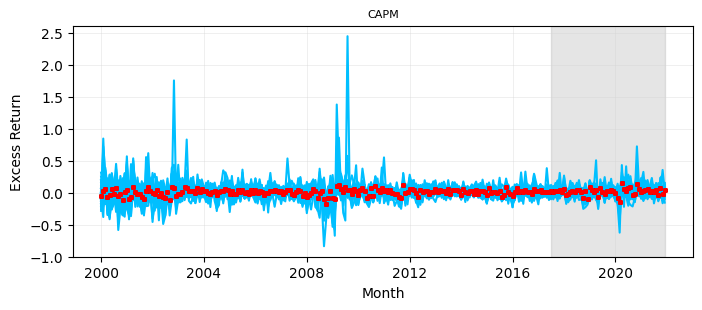

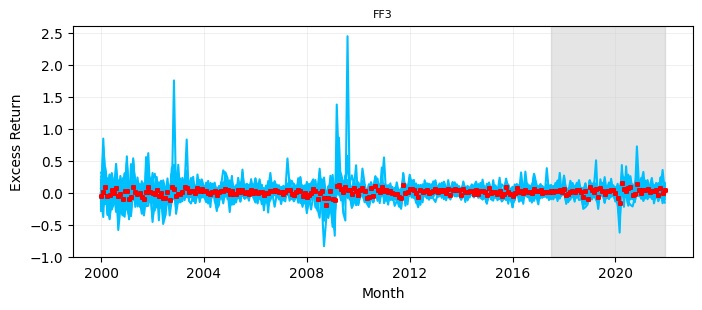

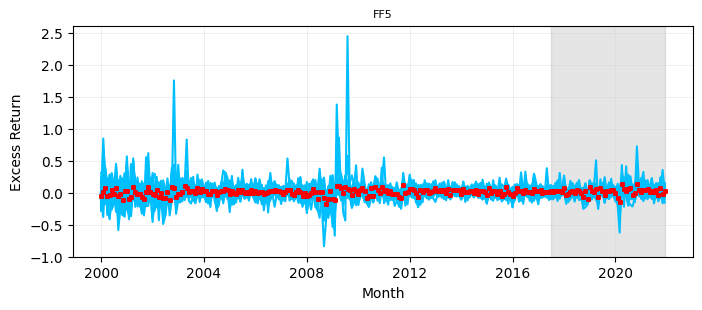

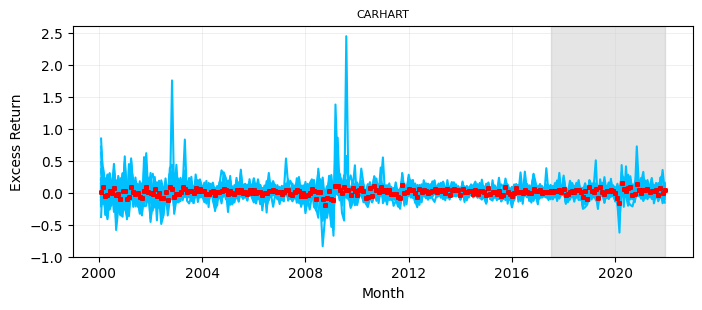

In [7]:
datasets = [(data_capm, y_pred_capm, y_fitted_capm, 'capm'),
            (data_ff3, y_pred_ff3, y_fitted_ff3, 'ff3'),
            (data_ff5, y_pred_ff5, y_fitted_ff5, 'ff5'),
           (data_carhart, y_pred_carhart, y_fitted_carhart, 'carhart')]

for data, y_pred, y_fitted, dataset_name in datasets:
    plot(data, y_pred, y_fitted, dataset_name)

### Regularization

In [6]:
def train_test_split_regularization(data):
    y = data['ret_excess']
    X = data.drop(columns = ['ret_excess'])
    scaler = StandardScaler()
    X_scaled_array = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array, index = X.index, columns = X.columns)
    # Training 80 pct.
    training_date = "2017-07-01"
    X_train = X_scaled[X.index.get_level_values('month') < training_date]
    X_test = X_scaled[X.index.get_level_values('month') >= training_date]
    y_train = y[y.index.get_level_values('month') < training_date]
    y_test = y[y.index.get_level_values('month') >= training_date]
    
    n_features = X_train.shape[1] # Number of features
    feature_names = data.drop(columns=['ret_excess']).columns.tolist() # Feature names
    
    n_features = X_train.shape[1] # Number of features
    feature_names = data.drop(columns=['ret_excess']).columns.tolist() # Feature names
    y_train_ = np.array(y_train).reshape(-1,1)
    return X_train, X_test, y_train, y_test, y_train_, n_features, feature_names

def optimal_alpha_EN(X_train,y_train_, l1_ratio):
    alphas = np.logspace(-6, 6, 100)
    
    lm_model = ElasticNet(alpha=0.006,
                          l1_ratio=l1_ratio,
                          max_iter=1000,
                          fit_intercept=False)
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=lm_model, param_grid={'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
    
    # Fit the grid search to the training data
    grid_search.fit(X_train.values, y_train_)
    best_alpha = grid_search.best_params_['alpha']
    best_alpha_str = "{:.10f}".format(round(best_alpha, 10))
    
    # Print the rounded alpha value
    print(f'Optimal Alpha: {best_alpha_str}')
    return best_alpha

def optimal_alpha_Ridge(X_train,y_train_):
    alphas = np.logspace(-6, 6, 100)
    
    lm_model = Ridge(alpha=0.006,
                          max_iter=1000,
                          fit_intercept=False)
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=lm_model, param_grid={'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
    
    # Fit the grid search to the training data
    grid_search.fit(X_train.values, y_train_)
    best_alpha = grid_search.best_params_['alpha']
    best_alpha_str = "{:.10f}".format(round(best_alpha, 10))
    
    # Print the rounded alpha value
    print(f'Optimal Alpha: {best_alpha_str}')
    return best_alpha

def EN_predict(X_train, y_train_, X_test, y_test, l1_ratio, alpha_opt):
    lm_model = ElasticNet(alpha=alpha_opt,
                          l1_ratio=l1_ratio,
                          max_iter=1000,
                          fit_intercept=False)
    
    lm_fit = lm_model.fit(X_train.values, y_train_)
    predictions = lm_fit.predict(X_test.values)
    fitted = lm_fit.predict(X_train.values)
    
    y_pred = pd.DataFrame(predictions, index = y_test.index)
    y_fitted = pd.DataFrame(fitted, index = y_train.index)
    
    y_pred.columns = ['predictions']
    y_fitted.columns = ['fitted_values']
    print(f'Out-of-sample R-squared =', round(R_oos(y_test, y_pred),4))
    return y_pred, y_fitted

def Ridge_predict(X_train, y_train_, X_test, y_test, alpha_opt):
    lm_model = Ridge(alpha=alpha_opt,
                          max_iter=1000,
                          fit_intercept=False)
    
    lm_fit = lm_model.fit(X_train.values, y_train_)
    predictions = lm_fit.predict(X_test.values)
    fitted = lm_fit.predict(X_train.values)
    
    y_pred = pd.DataFrame(predictions, index = y_test.index)
    y_fitted = pd.DataFrame(fitted, index = y_train.index)
    
    y_pred.columns = ['predictions']
    y_fitted.columns = ['fitted_values']
    print(f'Out-of-sample R-squared =', round(R_oos(y_test, y_pred),4))
    return y_pred, y_fitted
def plot(data, y_pred, y_fitted, dataset_name, regularizor):
    training_date = "2017-07-01"
    plt.figure(figsize=(8, 3))

    # Sort the DataFrame by index
    df_sorted = data.sort_index()
    y_pred = y_pred.sort_index()
    y_fitted = y_fitted.sort_index()
    # Plot line plots first
    for ticker in df_sorted.index.levels[0]:
        data_ticker = df_sorted.loc[ticker]
        plt.plot(data_ticker.index.get_level_values('month'), data_ticker['ret_excess'], label=ticker, color='deepskyblue')
        plt.scatter(y_pred.loc[ticker].index.get_level_values('month'), y_pred.loc[ticker]['predictions'], label=ticker, color='red', s=5, zorder=10, marker='o')
        plt.scatter(y_fitted.loc[ticker].index.get_level_values('month'), y_fitted.loc[ticker]['fitted_values'], label=ticker, color='red', s=5, zorder=10, marker='o')
    
    plt.axvspan(training_date, max(data.index.get_level_values('month')), color='gray', alpha=0.2)
    plt.grid(color='lightgray', linewidth=0.5, alpha=0.5)
    plt.title(f'{dataset_name.upper()}', size = 8)
    plt.xlabel('Month')
    plt.ylabel('Excess Return')

    # Save
    save_dir = 'plots/bm/regularization'
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the plot
    save_path = os.path.join(save_dir, f'{dataset_name.lower()}_plot_{regularizor}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
datasets = [data_capm, data_ff3, data_carhart, data_ff5]  # Assuming data_capm and data_ff5 are your datasets

for i, data in enumerate(datasets):
    # Create variable names based on dataset names
    dataset_name = ['capm', 'ff3', 'carhart','ff5'][i]  # Assuming dataset names are 'capm' and 'ff5'
    X_train_name = f'X_train_{dataset_name}'
    y_train_name = f'y_train_{dataset_name}'
    X_test_name = f'X_test_{dataset_name}'
    y_test_name = f'y_test_{dataset_name}'
    y_train__name = f'y_train__{dataset_name}'
    n_features_name = f'n_features_{dataset_name}'
    feature_names_name = f'n_feature_names_{dataset_name}' 
    y_pred_name = f'y_pred_{dataset_name}'
    y_fitted_name = f'y_fitted_{dataset_name}'
    
    # Split the data
    X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data)

    # Assign the train-test splits to the dynamically created variable names
    globals()[X_train_name] = X_train
    globals()[y_train_name] = y_train
    globals()[X_test_name] = X_test
    globals()[y_test_name] = y_test
    globals()[y_train__name] = y_train_
    globals()[n_features_name] = n_features
    globals()[feature_names_name] = feature_names

### Lasso

In [15]:
# CAPM
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_capm)
alpha_opt = optimal_alpha_EN(X_train_capm,y_train__capm,1)
y_pred, y_fitted = EN_predict(X_train_capm, y_train__capm, X_test_capm,y_test_capm, 1, alpha_opt)

Optimal Alpha: 0.0000010000
Out-of-sample R-squared = 0.3539


In [35]:
# ff3
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_ff3)
alpha_opt = optimal_alpha_EN(X_train,y_train_,1)
y_pred, y_fitted = EN_predict(X_train, y_train_, X_test,y_test, 1, alpha_opt)

Optimal Alpha: 0.0000010000
Out-of-sample R-squared = 0.3522


In [34]:
# carhart
X_train_carhart, X_test_carhart, y_train_carhart, y_test_carhart, y_train__carhart, n_features_carhart, feature_names_carhart = train_test_split_regularization(data_carhart)
alpha_opt = optimal_alpha_EN(X_train,y_train_,1)
y_pred_carhart, y_fitted = EN_predict(X_train, y_train_, X_test,y_test, 1, alpha_opt)

Optimal Alpha: 0.0000017475
Out-of-sample R-squared = 0.3529


In [33]:
# ff5
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_ff5)
alpha_opt = optimal_alpha_EN(X_train,y_train_,1)
y_pred, y_fitted = EN_predict(X_train, y_train_, X_test,y_test, 1, alpha_opt)

Optimal Alpha: 0.0000017475
Out-of-sample R-squared = 0.3529


In [191]:
#plot(data_capm, y_pred_capm, y_fitted_capm, dataset_name = 'CAPM', regularizor = 'Lasso')
#plot(data_ff3, y_pred_ff3, y_fitted_ff3, dataset_name = 'FF3', regularizor = 'Lasso')
#plot(data_ff5, y_pred_ff5, y_fitted_ff5, dataset_name = 'FF5', regularizor = 'Lasso')
#plot(data_carhart, y_pred_carhart, y_fitted_carhart, dataset_name = 'Carhart', regularizor = 'Lasso')

### EN 

In [192]:
# CAPM
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_capm)
alpha_opt = optimal_alpha_EN(X_train,y_train_,0.5)
y_pred, y_fitted = EN_predict(X_train, y_train_, X_test,y_test, 0.5, alpha_opt)

Optimal Alpha: 0.0000023101
Out-of-sample R-squared = 0.1497


In [31]:
# ff3
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_ff3)
alpha_opt = optimal_alpha_EN(X_train,y_train_,0.5)
y_pred, y_fitted = EN_predict(X_train, y_train_, X_test,y_test, 0.5, alpha_opt)

Optimal Alpha: 0.0000093260
Out-of-sample R-squared = 0.3522


In [194]:
# carhart
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_carhart)
alpha_opt = optimal_alpha_EN(X_train,y_train_,0.5)
y_pred, y_fitted = EN_predict(X_train, y_train_, X_test,y_test, 0.5, alpha_opt)

Optimal Alpha: 0.0000013219
Out-of-sample R-squared = 0.1703


In [32]:
# ff5
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_ff5)
alpha_opt = optimal_alpha_EN(X_train,y_train_,0.5)
y_pred, y_fitted = EN_predict(X_train, y_train_, X_test,y_test, 0.5, alpha_opt)

Optimal Alpha: 0.0000053367
Out-of-sample R-squared = 0.3529


In [196]:
#plot(data_capm, y_pred, y_fitted, dataset_name = '', regularizor = 'EN')
#plot(data_ff3, y_pred, y_fitted, dataset_name = '', regularizor = 'EN')
#plot(data_ff5, y_pred, y_fitted, dataset_name = '', regularizor = 'EN')

### Ridge

In [197]:
# CAPM
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_capm)
alpha_opt = optimal_alpha_Ridge(X_train,y_train_)
y_pred, y_fitted = Ridge_predict(X_train, y_train_, X_test,y_test, alpha_opt)

Optimal Alpha: 132.1941148466
Out-of-sample R-squared = 0.1497


In [198]:
# ff3
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_ff3)
alpha_opt = optimal_alpha_Ridge(X_train,y_train_)
y_pred, y_fitted = Ridge_predict(X_train, y_train_, X_test,y_test, alpha_opt)

Optimal Alpha: 231.0129700083
Out-of-sample R-squared = 0.1704


In [199]:
# carhart
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_carhart)
alpha_opt = optimal_alpha_Ridge(X_train,y_train_)
y_pred, y_fitted = Ridge_predict(X_train, y_train_, X_test,y_test, alpha_opt)

Optimal Alpha: 231.0129700083
Out-of-sample R-squared = 0.1703


In [200]:
# ff5
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data_ff5)
alpha_opt = optimal_alpha_Ridge(X_train,y_train_)
y_pred, y_fitted = Ridge_predict(X_train, y_train_, X_test,y_test, alpha_opt)

Optimal Alpha: 174.7528400008
Out-of-sample R-squared = 0.1704


In [201]:
#plot(data_capm, y_pred, y_fitted, dataset_name = '', regularizor = 'Ridge')
#plot(data_ff3, y_pred, y_fitted, dataset_name = '', regularizor = 'Ridge')
#plot(data_ff5, y_pred, y_fitted, dataset_name = '', regularizor = 'Ridge')

In [ ]:
def extract_selected_features(lm_pipeline, finder, data):
    # Fit the pipeline to the data
    lm_pipeline.fit(data.drop(columns=["ret_excess"]), data["ret_excess"])

    # Extract selected features based on the type of regression
    if 'lasso' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower() or 'elasticnet' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower():
        selected_features = pd.DataFrame(
            finder.best_estimator_.named_steps.regressor.coef_ != 0,
            index=lm_pipeline[:-1].named_steps.preprocessor.get_feature_names_out(),
            columns=["selected"]
        )
    elif 'ridge' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower():
        selected_features = pd.DataFrame(
            np.abs(finder.best_estimator_.named_steps.regressor.coef_) > 0.05, # Absolute value 
            index=lm_pipeline[:-1].named_steps.preprocessor.get_feature_names_out(),
            columns=["selected"]
        )
    else:
        raise ValueError("Unsupported regression type. Supported types: Lasso, Elastic Net, Ridge")
    
    # Remove prefixes from variable names if necessary
    selected_features.index = selected_features.index.str.replace("factor_|ff_|q_|macro_", "")

    return selected_features.astype(bool)

factors_Lasso = extract_selected_features(lm_pipeline_Lasso, finder_Lasso, data)
factors_Ridge = extract_selected_features(lm_pipeline_Ridge, finder_Ridge, data)
factors_EN = extract_selected_features(lm_pipeline_EN, finder_EN, data)
selected_factors = pd.concat([factors_Lasso,factors_Ridge,factors_EN], axis = 1)
selected_factors.reset_index(inplace=True)
selected_factors.columns = ['Factor', 'Lasso','Ridge','Elastic Net'] 
melted_factors = pd.melt(selected_factors, id_vars='Factor', var_name='Estimator', value_name='Selected')
melted_factors = melted_factors[melted_factors['Selected']]